Experiment 2: 

Run HMMM user who are on all 15 pages

In [1]:
import hmm_scaled
import os 

import pandas as pd 
import seaborn as sns 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from pyod.models.iforest import IForest

import warnings
warnings.filterwarnings("ignore")

In [2]:
def generate_dic(items): 
    """ Genderates a dictionay for all values in item """
    new_dic = {}
    count = 0
    for unique in items: 
        new_dic[unique]  = count
        count +=1
    return new_dic

def column_scaler(data): 
    """
    scales each column of data 
    """
    scaler = StandardScaler()
    for value in data.columns: 
        data_sub_ = pd.DataFrame(data.loc[:,value])
        data.loc[:,value] =scaler.fit_transform(data_sub_)
    return data

def kmean_prop(data, column): 
    data_value = data.groupby(column).agg(count = pd.NamedAgg(column= column, aggfunc= 'count'))
    percentage = []
    for i in range(0, len(data_value)): 
        result = round(((data_value.iloc[i,0] / len(data)) * 100),2)
         
        percentage.append(result)
    data_value['percentage (%)'] = percentage
        
    return data_value

def PCA_Col_names(count):
    """
    Remove columns in a PCA that meets the threshold count 
    """
    colname = []
    rowname = 1
    while rowname <= count: 
        colname.append(f'Principle Component {rowname}')
        rowname += 1 
    return (colname)

In [3]:
# set working directory (Change for youe)
os.chdir('C:/Users/ander/Google Drive/Columbia/Fall 2019/Capstone/Dotin-Columbia-Castone-Team-Alpha-')
data = pd.read_csv('Models/Q1_Mouse Activity/Data/direction_data.csv')
data = data.drop(columns='Unnamed: 0')

In [85]:
unique_user = set(data['User Id'])

In [99]:
user_to_include = []
for user in unique_user: 
    user_thresh_hold = data[data['User Id'] == user]['Page count'].value_counts() <= 100
    if sum(np.where(user_thresh_hold.values ==False, 1,0)) == 15: 
        user_to_include.append(user)
len(user_to_include)

39

In [4]:
# create a list with all the page number
page_number_list =[]
for value in range(1,16):
    page_ = f'page {value}'
    page_number_list.append(page_)

In [5]:
## limit page observation per page 
final_data = data[0:0]

for page in range(0,len(page_number_list)):
    observation_limit = 200
    page_subset =  data[data['Page count'] == page_number_list[page]]
    page_shrunk = page_subset[page_subset.observation <= observation_limit]
    page_ = page_shrunk.groupby('User Id').count()['observation']
    user_list = page_[page_  == observation_limit].index
    updated_dat = page_shrunk[page_shrunk['User Id'].isin(user_list)]
    final_data = pd.concat([final_data,updated_dat])

In [6]:
# count obse
for page in range(0,15):
    pages___ = final_data[final_data['Page count']== page_number_list[page]]
    user_count = len(pages___.groupby('User Id').count()['observation'])
    print(f' Page {page+1}: {user_count}')

 Page 1: 170
 Page 2: 221
 Page 3: 217
 Page 4: 206
 Page 5: 195
 Page 6: 188
 Page 7: 197
 Page 8: 194
 Page 9: 181
 Page 10: 180
 Page 11: 169
 Page 12: 151
 Page 13: 139
 Page 14: 119
 Page 15: 103


In [7]:
unique_page = set(data['Page count'])

In [8]:
final_data = data
user_list = []
page_count_list = []
for user in unique_user: 
    user_list.append(user)
    num_pages_completed = len(set(data[data['User Id'] == user]['Page count']))
    page_count_list.append(num_pages_completed)

In [9]:
num_pages_user = pd.DataFrame({'User Id': user_list, 
                          'Num page': page_count_list})
num_pages_user['Num page'].value_counts()

1     212
15     66
10     39
5      36
9      35
11     32
8      31
7      31
14     29
3      29
6      27
4      25
12     24
13     23
2      22
Name: Num page, dtype: int64

In [10]:
user_completed_all_page = num_pages_user[num_pages_user['Num page'] == 15]['User Id'].values

In [11]:
data = data[data['User Id'].isin(user_completed_all_page)]

In [12]:
user_direction = data[['User Id','Page count', 'Direction']]
flatten_data = user_direction.groupby(['User Id','Page count'], as_index=False).agg(list)

user_dict = generate_dic(set(data['Direction']))

direction_numerized =[]
for row in range(0,len(flatten_data)): 
    value = flatten_data.iloc[row,2]
    numerized =[user_dict.get(key, value) for key in value]
    direction_numerized.append(numerized)
flatten_data['Direction Numerized'] = direction_numerized

page_number_list =[]
for value in range(1,16):
    page_ = f'page {value}'
    page_number_list.append(page_)

In [13]:
user_fraud_matrix = pd.DataFrame(data=0 , index=user_completed_all_page, columns=unique_page)
user_fraud_matrix = user_fraud_matrix[page_number_list]

In [14]:
hmm= hmm_scaled.HMM(len(user_dict))

In [15]:
for count in range(0,len(page_number_list)):
    page_ = flatten_data[flatten_data['Page count'] == page_number_list[count]]
    page_= page_.set_index('User Id')
    hmm.fit(list(page_['Direction Numerized']))
    for index in user_fraud_matrix.index:
        try: 
            user_fraud_matrix.loc[index, page_number_list[count]] = hmm.log_likelihood(page_.loc[index, 'Direction Numerized'])
        except KeyError:
            continue

iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:10:13.102847
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:05:44.712004
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:05:16.396429
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:49.085343
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:05:42.498085
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:57.810255
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:05:14.695411
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:28.212744
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:05:01.507296
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:42.770539
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:47.054255
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:04.230906
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:03:43.648784
iteration: 0
iteration: 10
iteration: 20
Fit duration: 0:04:16.461560
iteration: 0
iterati

### Isolation forest

In [31]:
user_fraud_matrix = pd.read_csv('Models/Q1_Mouse Activity/Data/user_fraud_matrix.csv', index_col='Unnamed: 0')
user_fraud_matrix_scaled = column_scaler(user_fraud_matrix)
user_fraud_matrix_scaled = user_fraud_matrix_scaled[page_number_list]

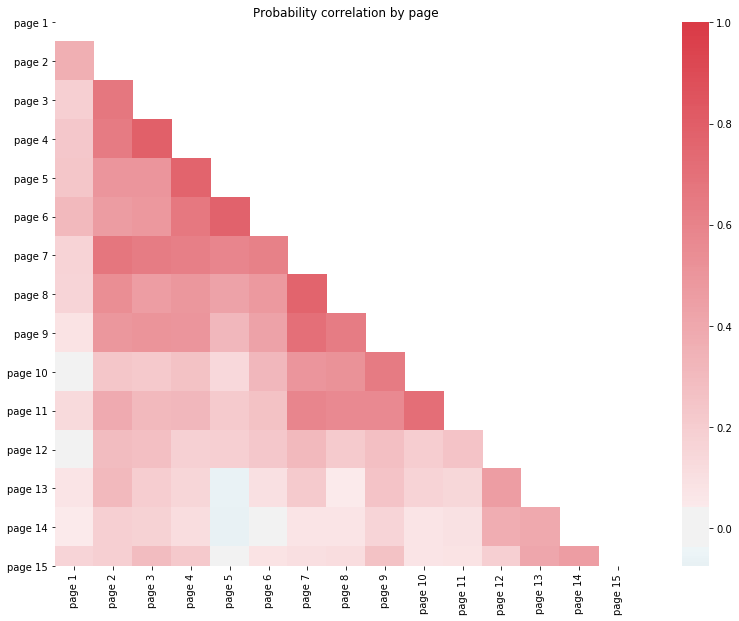

In [17]:
fig = plt.figure(figsize=(16,10))
corr = user_fraud_matrix_scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.title('Probability correlation by page')
plt.show()

In [125]:
round(user_fraud_matrix_scaled,3)

,page 1,page 2,page 3,page 4,page 5,page 6,page 7,page 8,page 9,page 10,page 11,page 12,page 13,page 14,page 15
384,0.548,0.533,-0.022,-0.714,0.648,0.818,0.795,0.326,0.618,0.675,0.617,0.784,0.900,0.776,0.700
422,-2.184,-5.829,-4.181,-4.445,-4.693,-4.275,-6.126,-4.628,-4.139,-1.509,-2.916,-1.492,-0.605,-0.314,-0.380
448,0.563,0.949,0.500,-0.185,1.068,1.426,0.280,0.532,0.619,0.539,-0.148,0.667,-0.477,0.491,0.129
507,0.567,0.458,-0.333,0.172,-0.050,0.022,0.274,-0.681,-0.240,0.947,0.867,0.978,1.140,1.175,0.667
549,0.202,0.890,0.746,0.769,0.563,1.001,0.930,0.746,0.888,0.676,0.720,-0.408,-1.199,-1.342,-2.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.592,-0.613,-0.717,0.078,0.905,-0.541,0.672,0.312,-1.063,0.315,0.376,0.344,0.352,0.055,-1.708
1568,-1.513,-0.315,0.543,0.547,0.558,-0.162,0.516,0.337,0.547,0.286,0.382,0.427,-0.354,-1.253,0.754
1572,0.632,0.723,0.473,0.299,0.555,0.824,0.090,-0.578,-0.545,-0.250,-0.055,0.654,0.738,0.717,0.912
1576,0.634,0.794,0.345,0.046,-0.221,-0.913,-1.013,0.759,0.536,-1.160,-0.307,0.731,-1.124,0.543,0.793


In [20]:
iforest_1 = IForest(behaviour="new", bootstrap=True,n_jobs=-1,) 
iforest_1= iforest_1.fit_predict(user_fraud_matrix_scaled)


In [21]:
unique, counts = np.unique(iforest_1,return_counts=True)
dict(zip(unique, counts))

{0: 59, 1: 7}

In [127]:
user_fraud_matrix_scaled['Iforest_1'] = np.where(iforest_1 == 0, 'Normal', 'Risk')
user_fraud_matrix_scaled.to_csv('Models/Q1_Mouse Activity/Data/user_fraud_matrix_labeled.csv')

,page 1,page 2,page 3,page 4,page 5,page 6,page 7,page 8,page 9,page 10,page 11,page 12,page 13,page 14,page 15,Iforest_1
384,0.547905,0.533302,-0.022079,-0.713886,0.648089,0.817825,0.795418,0.326318,0.618381,0.675036,0.616861,0.784337,0.899531,0.776315,0.700123,Normal
422,-2.183712,-5.828676,-4.181490,-4.445188,-4.693307,-4.274546,-6.125894,-4.628268,-4.138891,-1.508994,-2.916452,-1.491649,-0.604758,-0.314440,-0.379609,Risk
448,0.563158,0.948610,0.500342,-0.185274,1.068358,1.426200,0.280293,0.532172,0.619003,0.538879,-0.148098,0.666721,-0.476851,0.490687,0.128982,Normal
507,0.567136,0.457601,-0.332559,0.172191,-0.049767,0.021701,0.274258,-0.681436,-0.240067,0.946563,0.867124,0.977622,1.140465,1.174817,0.667401,Normal
549,0.202354,0.889611,0.745979,0.768591,0.563448,1.000796,0.930317,0.746184,0.888134,0.675991,0.720339,-0.407792,-1.199191,-1.341820,-2.574372,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.591775,-0.612885,-0.716729,0.078050,0.904503,-0.540615,0.671649,0.312072,-1.063263,0.315244,0.375718,0.344111,0.351948,0.055007,-1.708457,Normal
1568,-1.512649,-0.315025,0.542887,0.546552,0.558000,-0.162148,0.516478,0.337230,0.546708,0.286403,0.382309,0.427034,-0.354052,-1.252694,0.753973,Normal
1572,0.631728,0.722909,0.472814,0.299393,0.554779,0.824423,0.089514,-0.578007,-0.544514,-0.250472,-0.055451,0.654430,0.738115,0.717222,0.911808,Normal
1576,0.633971,0.793616,0.344697,0.046012,-0.220734,-0.912516,-1.012749,0.758914,0.536312,-1.159985,-0.306571,0.730854,-1.124363,0.543321,0.792699,Normal


In [23]:
user_fraud_matrix_scaled[user_fraud_matrix_scaled.Iforest_1== 'Risk']

,page 1,page 2,page 3,page 4,page 5,page 6,page 7,page 8,page 9,page 10,page 11,page 12,page 13,page 14,page 15,Iforest_1
422,-2.183712,-5.828676,-4.181490,-4.445188,-4.693307,-4.274546,-6.125894,-4.628268,-4.138891,-1.508994,-2.916452,-1.491649,-0.604758,-0.314440,-0.379609,Risk
727,-0.202614,-1.288524,-1.540978,-2.275778,-0.445298,-1.584552,-1.974968,-1.823290,-4.174004,-2.587013,-1.823522,-1.661425,-3.521579,-2.754341,-3.487638,Risk
866,-0.254270,-0.550579,-0.804950,-2.098284,-2.465853,-2.757636,-0.404033,0.007019,0.481451,-1.273219,0.020065,-1.784863,0.344770,-0.623173,0.219069,Risk
1272,-0.342062,1.120141,0.977275,-1.051740,-2.426578,-1.713342,1.210826,0.966093,1.165767,0.961911,0.971380,1.157981,1.446635,1.279634,0.973207,Risk
1297,0.047205,0.132114,-0.027132,0.371317,0.652262,-0.041159,-1.134578,-1.933471,-1.224167,-5.476701,-3.737193,1.098760,1.431168,1.327531,0.991720,Risk
1314,-0.255617,-0.132413,-2.594779,-2.371436,-1.754235,-1.253281,-1.046762,0.667358,0.655714,0.621472,-0.179494,-0.183090,-0.006789,-0.149998,-0.269883,Risk
1495,-0.468345,-2.110980,-2.617049,-2.763410,-0.962960,-0.381544,-0.347351,-1.187253,-0.738828,-0.654655,-0.736261,-0.789223,-0.511677,-0.774498,-1.831863,Risk


In [24]:
validations = pd.read_csv('Data/validations.csv')
validations_userid_fraud = validations[validations.validation == False]['user_id']

In [25]:
results_over_lap = validations_userid_fraud.isin(user_fraud_matrix_scaled[user_fraud_matrix_scaled.Iforest_1== 'Risk'].index)

In [26]:
validations_userid_fraud[results_over_lap == True]

130     727
174     866
368    1272
Name: user_id, dtype: int64

In [27]:
user_direction_summary = pd.read_csv('Models/Q1_Mouse Activity/Data/user_direction_summary.csv')
user_direction_summary = user_direction_summary.drop(columns='Unnamed: 0')

In [28]:
def plot_movement(user_id, page_number, user_label):
    user_data = user_direction_summary[user_direction_summary['user_id'] == user_id]
    user_data = user_data[user_data['direction'] == page_number]
    plt.plot('cord_x','cord_y',data=user_data)
    plt.xlim(0,1366)
    plt.ylim(0,728)
    plt.title(f'User {user_id} mouse movement for {page_number}: {user_label} ')
    plt.show()

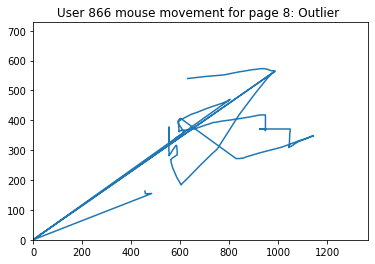

In [121]:
plot_movement(866, page_number_list[7],'Outlier')

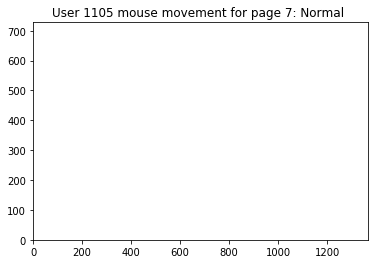

In [122]:
plot_movement(1105, page_number_list[6],'Normal')